In [2]:
# from utils import solve_graph_weights, log2_comb, dig_sparse_level, MyNeighbour,comp_quant_encoding
from scipy.linalg import hadamard
from scipy.special import binom
import numpy as np
import matplotlib.pyplot as plt
import networkx as net
import pandas as pd
import pickle
import itertools
from functools import partial
from sklearn.linear_model import Lasso, OrthogonalMatchingPursuit
import cvxpy as cvx
import plotly.express as pltly

In [3]:
np.set_printoptions(suppress = True)

parameters for $\mu-L$ convergence
* $\mu = \lambda$       regularization parameter

In [4]:
# train_images=train_images.reshape((60000,784),order='C')
# SampleCov=[(train_images[sample_indices[i]].T @ train_images[sample_indices[i]]) / len(sample_indices[i]) for i in range(K)]
# lambdaSampleCov=[np.linalg.eigvalsh(SampleCov[i]).reshape((784,1)) for i in range(K)]
# E = 1./2*(np.eye(K) - np.ones((K,1)) @ np.ones((1,K)) / K)
# lambdaE=np.linalg.eigvalsh(E).reshape((K,1))
# lambda_base = [max(.5*lambdaSampleCov[i]).squeeze() for i in range(K)]
lamda = .1
# L = max(lambda_base) + lamda
L = .3298 + lamda
mu = lamda
kappa = L / mu
gb = .1 # as the norm bound G for gradient
K = 20
d = 7850
N = 1e4
M= 2
m = N/(2*M) # N/(2*M), where 2M is the total number of scheduling slots for M-round 'star-like' commun.
rho = 1e6 #average SNR ~40dB

seeds = iter(range(1000))
p = 0.2
alg_connect = 0
while alg_connect < 1e-4:
#     ER = net.erdos_renyi_graph(K-1, .2, seed = next(seeds))
#     ER.add_node(K-1)
#     G = net.star_graph(reversed(range(K)))
#     G.add_edges_from(ER.edges())
    G = net.erdos_renyi_graph(K, p, seed = next(seeds))
    pos = net.spring_layout(G)
    LP = np.array(net.laplacian_matrix(G).todense())
    D, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
    alg_connect = D[1] 
alpha = 2 / (D[K-1] + D[1])
W = np.eye(K) - alpha * LP
# pos = net.spring_layout(G)
# net.draw(G, pos, with_labels = True, node_size = 500, edge_size = 300, font_size = 16)

beta = np.linalg.norm(np.eye(K) - W, ord=2)
delta = 1 - np.linalg.norm(np.ones((K,1)) @ np.ones((1,K)) / K - W, ord=2)
omega = m/d
zeta_ini = delta * omega / (16*delta + delta**2 + 4*beta**2 + 2*delta*beta**2 - 8*delta*omega)
# b = 6/mu
# a = 24 * kappa
# c = 100
if (delta**2/4 + 2/omega * beta**2)*zeta_ini - delta <=0:
    a_prime = 40072.
else:
    a_prime = .99 * delta / ((delta**2/4 + 2/omega * beta**2)*zeta_ini - delta)
        
# eta = lambda t: b/(t+a)
zeta = lambda t: zeta_ini /(t/a_prime+1)
p = lambda t: -(delta**2 * zeta_ini**2/4 + 2*beta**2 * zeta_ini**2/omega)/((t/a_prime+1)**2) + delta*zeta_ini/(t/a_prime+1)
# eta = lambda t: c*p(t)**(1.4)
c = .999 * (delta * zeta_ini - (delta**2/4 + 2/omega * beta**2) * zeta_ini**2 / (1/a_prime + 1))
D = 13 * np.sqrt(2) * gb / (mu * c * a_prime)
eta = lambda t: D / (2*np.sqrt(2) * gb) * c / (t/a_prime+1)

# a1, a3 = lambda t: 2/p(t), lambda t: 2/p(t)
a2 = lambda t: delta*zeta(t) / 2
a4 = omega/2

In [623]:
# Set distances among any pair of nodes
d_min = 50
d_max = 200
rho =  d_min + (d_max - d_min) * np.random.rand(K,1) 
theta = 2 * np.pi * np.random.rand(K,1)
# D = np.ones((K, K))
D = np.sqrt(rho ** 2 + rho.T ** 2 - 2 * (rho @ rho.T) * np.cos(theta - theta.T))
for i in range(K):
    if i:
        D[i,i] = D[i,i-1]
    else:
        D[i,i] = D[i,i+1]
        
A0 = 10 ** (-3.35)
d0 = 1
gamma = 3.76
PL = A0 * ((D / d0) ** (-gamma))
# Generate per-iteration channels following Rayleigh fading
CH_gen = iter( np.random.randn(len(G.edges()),)/np.sqrt(2) + 1j * np.random.randn(len(G.edges()),)/np.sqrt(2) )
CH = np.ones((K, K), dtype=complex)  # Channel coefficients
for i in range(K):
    for j in G[i]:
        if j < i:
            CH[i, j] = next(CH_gen)
for i in range(K):
    for j in G[i]:
        if j > i:
            CH[i, j] = np.conjugate(CH[j, i])
CG = PL * (np.abs(CH)) ** 2 

In [42]:
# For an ER graph of connectivity probability of p = 0.20
# losseses = pickle.load( open('../repo_jv/data/losseses_SCHEME_5_eta0_2.00_zeta0_0.0010_rho_a_prime_100_10-0.pkl', 'rb') )
# losseses = np.array(losseses)
# K = losseses.shape[2]
# df1 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )
losseses = pickle.load( open('../repo_jv/data/losseses_SCHEME_5_P_0.02_N_50119_eta0_1.00_zeta0_0.0010_rho_a_2.00.pkl', 'rb') )
losseses = np.array(losseses)
df1 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = pickle.load( open('../repo_jv/data/losseses_SCHEME_5_P_0.02_N_19953_eta0_1.00_zeta0_0.0100_rho_a_3.0.pkl', 'rb') )
losseses = np.array(losseses)
df2 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = pickle.load( open('../repo_jv/data/losseses_SCHEME_5_P_0.02_N_50119_eta0_1.00_zeta0_0.0100_rho_a_0.80.pkl', 'rb') )
losseses = np.array(losseses)
df3 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = pickle.load( open('../repo_jv/data/losseses_SCHEME_5_P_0.02_N_50119_eta0_1.00_zeta0_0.1000_rho_a_0.05.pkl', 'rb') )
losseses = np.array(losseses)
df4 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = pickle.load( open('../repo_jv/data/losseses_SCHEME_5_P_0.02_N_50119_eta0_1.00_zeta0_0.1000_rho_a_0.20.pkl', 'rb') )
losseses = np.array(losseses)
df5 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = pickle.load( open('../repo_jv/data/losseses_SCHEME_5_P_0.02_N_50119_eta0_1.00_zeta0_0.1000_rho_a_0.50.pkl', 'rb') )
losseses = np.array(losseses)
df6 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = pickle.load( open('../repo_jv/data/losseses_SCHEME_5_P_0.02_N_50119_eta0_1.00_zeta0_0.1000_rho_a_1.00.pkl', 'rb') )
losseses = np.array(losseses)
df7 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = pickle.load( open('../repo_jv/data/losseses_SCHEME_5_P_0.02_N_50119_eta0_1.00_zeta0_0.1000_rho_a_2.00.pkl', 'rb') )
losseses = np.array(losseses)
df8 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

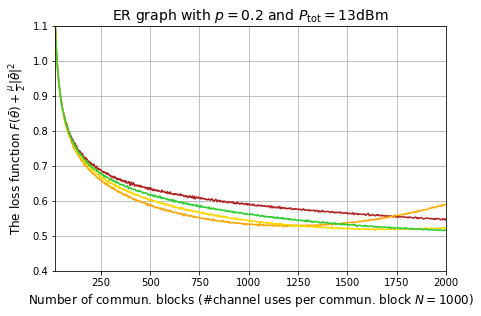

In [43]:
fig, ax = plt.subplots(figsize = (7.0,4.5))
df1.rolling(window = 5).mean().mean(axis = 1).plot(color = 'firebrick', label = 'D-DSGD')
df2.rolling(window = 5).mean().mean(axis = 1).plot(color = 'orange', label = 'TDMA-based D-DSGD')
df3.rolling(window = 5).mean().mean(axis = 1).plot(color = 'gold', label = 'A-DSGD')
df4.rolling(window = 5).mean().mean(axis = 1).plot(color = 'limegreen', label = 'TDMA-based A-DSGD')
# df5.rolling(window = 5).mean().mean(axis = 1).plot(color = 'cyan', label = 'TDMA-based A-DSGD')
# df6.rolling(window = 5).mean().mean(axis = 1).plot(color = 'tab:blue', label = 'TDMA-based A-DSGD')
# df7.rolling(window = 5).mean().mean(axis = 1).plot(style = '--', color = 'blueviolet', label = 'Ideal commun.')
# df8.rolling(window = 5).mean().mean(axis = 1).plot(color = 'tab:green', label = 'No commun.')

plt.xlabel(r'Number of commun. blocks (#channel uses per commun. block $N = 1000$)', fontsize = 12)
plt.ylabel(r'The loss function $F(\bar{\theta}) + \frac{\mu}{2}\|\bar{\theta}\|^2$', fontsize = 12)
plt.title(r'ER graph with $p = 0.2$ and $P_{\rm tot} = 13$dBm', fontsize = 14)
plt.xlim((20, 2000))
plt.ylim((0.4, 1.10))
plt.grid()
# plt.legend(loc = 'upper right', fontsize = 12)
# plt.savefig('C:/Users/Helen/documents/visiting_research@KCL/D2D_DSGD/repo_jv/fig/comp_loss_vs_commun_small_N.pdf',format='pdf', dpi=600)
plt.show()

In [39]:
df3.rolling(window = 5).mean().mean(axis = 1).min()

0.515690454542637

In [946]:
# For an ER graph of connectivity probability of p = 0.10 generated based on a STAR
# standard DSGD
losseses = pickle.load( open('../repo_jv/data/losseses_SCHEME_1_eta0_2.00_zeta0_1.00_10-0.pkl', 'rb') )
losseses = np.array(losseses)
df1 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )
# digital implementation of DSGD with the proposed scheduling
losseses = pickle.load( open('../repo_jv/data/losseses_SCHEME_3_eta0_2.00_zeta0_0.1000_star-based_p_0.10_med_N.pkl', 'rb') )
losseses = np.array(losseses)
df5 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )
# digital implementation of DSGD with TDMA
losseses = pickle.load( open('../repo_jv/data/losseses_SCHEME_5_eta0_1.00_zeta0_0.0100_rho_a_5.0_star-based_p_0.10_med_N.pkl', 'rb') )
losseses = np.array(losseses)
df6 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )
# analog implementation of DSGD with the sequential scheduling (obtain the smalliest #slots)
losseses = pickle.load( open('../repo_jv/data/losseses_SCHEME_5_M_8_eta0_1.00_zeta0_0.0100_rho_a_5.0_star-based_p_0.10_med_N.pkl', 'rb') )
losseses = np.array(losseses)
df3 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )
# analog implementation of DSGD with TDMA (obtain the largest #slots)
losseses = pickle.load( open('../repo_jv/data/losseses_SCHEME_6_eta0_1.00_zeta0_0.0100_rho_a_5.0_star-based_p_0.10_med_N.pkl', 'rb') )
losseses = np.array(losseses)
df4 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )
# independent training w/o communications
losseses = pickle.load( open('../repo_jv/data/losseses_local_eta0_2.00.pkl', 'rb') )
losseses = np.array(losseses)
df0 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

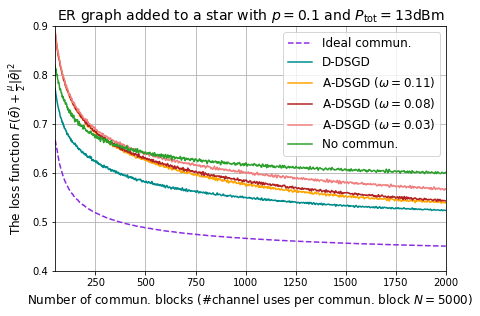

In [947]:
fig, ax = plt.subplots(figsize = (7.0,4.5))
df1.rolling(window = 5).mean().mean(axis = 1).plot(style = '--', color = 'blueviolet', label = 'Ideal commun.')
df5.rolling(window = 5).mean().mean(axis = 1).plot(color = 'darkcyan', label = 'D-DSGD')
df6.rolling(window = 5).mean().mean(axis = 1).plot(color = 'orange', label = r'A-DSGD ($\omega = 0.11$)')
df3.rolling(window = 5).mean().mean(axis = 1).plot(color = 'firebrick', label = r'A-DSGD ($\omega = 0.08$)')
df4.rolling(window = 5).mean().mean(axis = 1).plot(color = 'lightcoral', label = r'A-DSGD ($\omega = 0.03$)')
df0.rolling(window = 5).mean().mean(axis = 1).plot(color = 'tab:green', label = 'No commun.')

plt.xlabel(r'Number of commun. blocks (#channel uses per commun. block $N = 5000$)', fontsize = 12)
plt.ylabel(r'The loss function $F(\bar{\theta}) + \frac{\mu}{2}\|\bar{\theta}\|^2$', fontsize = 12)
plt.title(r'ER graph added to a star with $p = 0.1$ and $P_{\rm tot} = 13$dBm', fontsize = 14)
plt.xlim((50, 2000))
plt.ylim((0.4, 0.90))
plt.grid()

plt.legend(loc = 'upper right', fontsize = 12)
# plt.savefig('C:/Users/Helen/documents/visiting_research@KCL/D2D_DSGD/repo_jv/fig/comp_loss_vs_commun_star-based_med_N.pdf',format='pdf', dpi=600)
plt.show()

In [943]:
df6.rolling(window = 5).mean().mean(axis = 1).min()

0.538049122095108

In [832]:
import sys

In [7]:
5011.9 / 7850

0.6384585987261147

Generate a partial Hadamard matrix $H \in \{\pm 1\}^{m\times d}$

In [53]:
tilde_d = 2 ** 13
H = hadamard(tilde_d)
d = 7850
m = int(d / 1)
H_par = H[:m]

In [54]:
theta = np.random.randn(d,)
tilde_theta = np.concatenate((theta, np.zeros((2**13 - d,))), axis = 0)

In [55]:
n, p, tilde_d = 1, .5, 2 ** 13
r = np.random.binomial(n, p, (tilde_d,))
r[r == 0] = -1
temp = [H_par[i,:] * r for i in range(m)]
A = (1 / np.sqrt(m)) * np.array(temp)
est_theta = m/tilde_d * (A.T  @ (A @ tilde_theta))
est_theta = est_theta[:d]

In [59]:
(np.linalg.norm(est_theta - theta))**2 

268.0075239637175

In [60]:
(1 - m / tilde_d) * np.linalg.norm(theta)**2

327.9351916516721

In [162]:
g = net.Graph()

In [167]:
not G

False

Sequential scheduling on the connectivity graph $\mathcal{G}(\mathcal{V}, \mathcal{E})$

In [535]:
def TwoSectionH(G): # Generate the 2-section of the proposed hypergraph, i.e., H2
    # VertexH = G.nodes()
    Hyperedge = [ tuple(sorted([node] + [n for n in G.neighbors(node)])) 
                                    for node in G.nodes() ] # construct a hypergraph each of whose hyperedge consists of a node and its neighbours
    Hyperedge = list(set(Hyperedge)) # remove any repeated hyperedges
    H2Edges = [[tuple(sorted(e)) for e in net.complete_graph(he).edges()] for he in Hyperedge] # a list of list of edges of H2
    temp = [] # remove the inner list
    for e in H2Edges:
        temp.extend(e)
    H2Edges = list(set(temp)) # remove any repeated edges

    H2 = net.Graph()
    H2.add_nodes_from(G.nodes())
    H2.add_edges_from(H2Edges)
    vertex_color_map = net.greedy_color(H2, strategy = 'saturation_largest_first') # vertex coloring H2
    
    return H2, vertex_color_map

In [536]:
def seq_scheduling(G):
    # A sequential list (slot's) of star toplogy-based schedule in a form of dicts 
    Rx_schedule_list = [] 
    # key-value pair herein is node (n_b, n_c), where n_b is the #times for which a node transmits as a star center (BC), 
    # and n_c is the #times for which a node transmits to a star center
    Tx_times = {node:[0,0] for node in G.nodes()} 

    while G:
        _, from_node_to_color_id = TwoSectionH(G)
        color_degree = {c: sum( len(G[node]) for node, color in from_node_to_color_id.items() if color == c ) 
                             for c in from_node_to_color_id.values()}
        chosen_color = list(color_degree.values()).index(max(color_degree.values())) # find arg_max(degree(color_list))

        # A dict including (star center: associated nodes) pairs that transmits or recieves in parallel at the current slot
        Rx_schedule_dict = { node:G[node] for node, color in from_node_to_color_id.items() if color == chosen_color}
        # Append the scheule in the current slot to the sequential schedule list
        Rx_schedule_list.append(Rx_schedule_dict)
        # Update n_b for the star center
        for node in Rx_schedule_dict.keys():
            Tx_times[node][0] += 1
        # Update n_c for the neighbors of the star centers
        for neighbors in Rx_schedule_dict.values():
            for node in neighbors:
                Tx_times[node][1] += 1

        # Update the graph
        # Remove the scheduled Rxs, i.e., the star centers
        G.remove_nodes_from(Rx_schedule_dict.keys())
        # Remove any standalone nodes
        current_node_list = list(G.nodes())
        for node in current_node_list:
            if not(G[node]):
                G.remove_node(node)
   
    return Rx_schedule_list, Tx_times

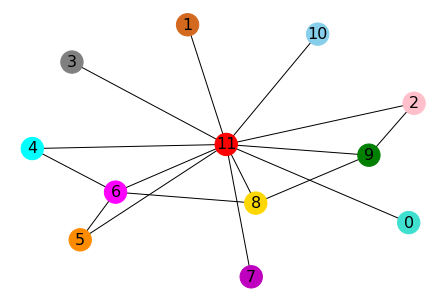

In [542]:
K = 12
seeds = iter(range(1000))
p = 0.2
#     ER = net.erdos_renyi_graph(K-1, .2, seed = next(seeds))
#     ER.add_node(K-1)
#     G = net.star_graph(reversed(range(K)))
#     G.add_edges_from(ER.edges())
G = net.erdos_renyi_graph(K, p, seed = next(seeds))

color_list = ['red', 'skyblue', 'green', 'gold', 'm', 'magenta', 'darkorange', 'cyan','gray', 'pink', 
              'chocolate', 'turquoise', 'olive', 'blueviolet', 'lightgreen', 'brown', 'royalblue', 'limegreen', 
              'darkcyan', 'snow']
H2, from_node_to_color_id = TwoSectionH(G)
node_color_pairs = [ color_list[ from_node_to_color_id[node] ] for node in H2.nodes() ]
net.draw(G, pos, with_labels = True, node_color = node_color_pairs, node_size = 500, font_size = 16)

In [558]:
temp1 = G.copy()
schedule_list, Tx_times = seq_scheduling(temp1)
schedule_list

[{11: AtlasView({10: {}, 9: {}, 8: {}, 7: {}, 6: {}, 5: {}, 4: {}, 3: {}, 2: {}, 1: {}, 0: {}})},
 {6: AtlasView({8: {}, 4: {}, 5: {}}), 2: AtlasView({9: {}})},
 {9: AtlasView({8: {}})}]

In [573]:
Tx_times

{11: [1, 0],
 10: [0, 1],
 9: (1, 2),
 8: [0, 3],
 7: [0, 1],
 6: [1, 1],
 5: [0, 2],
 4: [0, 2],
 3: [0, 1],
 2: [1, 1],
 1: [0, 1],
 0: [0, 1]}

In [572]:
len(Rx_times)

12

In [569]:
Rx_times ={node:sum(Tx_times[node]) for node in G.nodes()}

In [592]:
bool(schedule_list[0].get(10))

False

In [544]:
temp2 = G.copy()
color_degree = {c: sum( len(temp2[node]) for node, color in from_node_to_color_id.items() if color == c ) 
                     for c in from_node_to_color_id.values()}
chosen_color = list(color_degree.values()).index(max(color_degree.values())) # find arg_max(degree(color_list))

# A dict including (star center: associated nodes) pairs that transmits or recieves in parallel at the current slot
Rx_schedule_dict = { node:temp2[node] for node, color in from_node_to_color_id.items() if color == chosen_color}
Rx_schedule_dict

{11: AtlasView({10: {}, 9: {}, 8: {}, 7: {}, 6: {}, 5: {}, 4: {}, 3: {}, 2: {}, 1: {}, 0: {}})}

In [545]:
temp2.remove_nodes_from(Rx_schedule_dict.keys())
# Remove any standalone nodes
current_node_list = list(temp2.nodes())

False

In [548]:
temp2.remove_nodes_from([0,1,3,7,10])

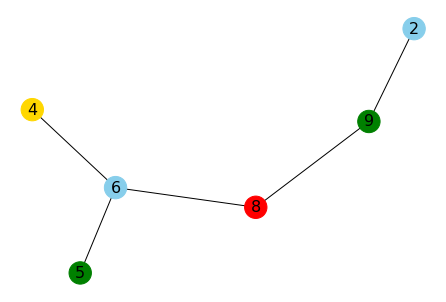

In [551]:
H2, from_node_to_color_id = TwoSectionH(temp2)
node_color_pairs = [ color_list[ from_node_to_color_id[node] ] for node in H2.nodes() ]
net.draw(temp2, pos, with_labels = True, node_color = node_color_pairs, node_size = 500, font_size = 16)

In [552]:
color_degree = {c: sum( len(temp2[node]) for node, color in from_node_to_color_id.items() if color == c ) 
                             for c in from_node_to_color_id.values()}
chosen_color = list(color_degree.values()).index(max(color_degree.values())) # find arg_max(degree(color_list))
chosen_color

1

In [553]:
Rx_schedule_dict = { node:G[node] for node, color in from_node_to_color_id.items() if color == chosen_color}

In [554]:
Rx_schedule_dict

{6: AtlasView({11: {}, 4: {}, 5: {}, 8: {}}), 2: AtlasView({11: {}, 9: {}})}

In [555]:
temp2.remove_nodes_from(Rx_schedule_dict.keys())

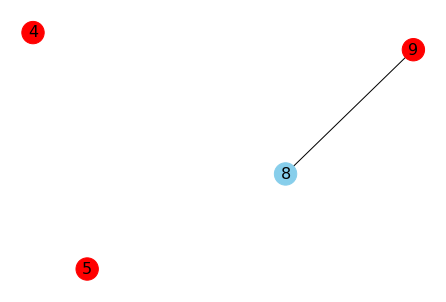

In [556]:
H2, from_node_to_color_id = TwoSectionH(temp2)
node_color_pairs = [ color_list[ from_node_to_color_id[node] ] for node in H2.nodes() ]
net.draw(temp2, pos, with_labels = True, node_color = node_color_pairs, node_size = 500, font_size = 16)

In [828]:
p = .1
ER = net.erdos_renyi_graph(K-1, p, seed = next(seeds))
Labels = net.relabel_nodes(ER, {node:node + 1 for node in ER.nodes()}, copy = False)
ER.add_node(0)
G = net.star_graph(K-1)
G.add_edges_from(ER.edges())

In [829]:
G.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19))

In [65]:
P_array = np.logspace(1.3, 3, 8) * 1e-3
a = 2000/1 * P_array[7]/P_array[0]
rho_a = .8 * P_array[7]/P_array[0]

In [66]:
rho_a

40.09497869018178

In [41]:
N_array = np.logspace(2.70, 4.70, 6)
N_array

array([  501.18723363,  1258.92541179,  3162.27766017,  7943.28234724,
       19952.62314969, 50118.72336273])

In [48]:
" ".join( "{:d}".format(int(x)) for x in N_array )

'501 1258 3162 7943 19952 50118'